# Model 2: Stacking

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, classification_report, f1_score, fbeta_score, make_scorer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.compose import make_column_transformer
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as imb_pipeline

from xgboost import XGBClassifier



pd.set_option('display.float_format', lambda x: '%.2f' % x)
RSEED = 42

In [2]:
# df = pd.read_csv('data/cleaned/train.csv')
# df_test = pd.read_csv('data/cleaned/test.csv')
df = pd.read_csv('data/cleaned/train_extended.csv')
df_test = pd.read_csv('data/cleaned/test_extended.csv')
df.head()


,district,client_id,client_catg,region,reading_remarque_6,reading_remarque_7,reading_remarque_8,reading_remarque_9,reading_remarque_413,counter_statue_0,...,counter_coefficient_30,counter_coefficient_33,counter_coefficient_40,counter_coefficient_50,counter_code_count_unique,counter_number_count_unique,counter_type_count_unique,months_number,consommation_sum,target
0,60,train_Client_29310,11,101,18,0,6,34,0,56,...,0,0,0,0,2,3,2,3.93,734.81,0.00
1,63,train_Client_128477,11,312,1,0,2,1,0,4,...,0,0,0,0,1,1,1,3.50,325.75,0.00
2,63,train_Client_56966,11,311,40,0,15,23,0,78,...,0,0,0,0,2,2,2,4.21,537.35,0.00
3,69,train_Client_23694,11,104,0,0,3,17,0,20,...,0,0,0,0,2,2,2,4.00,762.45,0.00
4,62,train_Client_12064,11,309,2,0,0,24,0,26,...,0,0,0,0,2,2,2,4.00,375.73,0.00


## Split Target, Drop ID

In [3]:
y_train = df['target']
X_train = df.drop(['target', 'client_id'], axis=1)

In [4]:
# Helper: Check specific columns:
X_train.iloc[:,5].sort_values(ascending=False).nunique()

46

In [5]:
# Helper (compare X_train and X_test below):
X_train.head(2)

,district,client_catg,region,reading_remarque_6,reading_remarque_7,reading_remarque_8,reading_remarque_9,reading_remarque_413,counter_statue_0,counter_statue_1,...,counter_coefficient_20,counter_coefficient_30,counter_coefficient_33,counter_coefficient_40,counter_coefficient_50,counter_code_count_unique,counter_number_count_unique,counter_type_count_unique,months_number,consommation_sum
0,60,11,101,18,0,6,34,0,56,1,...,0,0,0,0,0,2,3,2,3.93,734.81
1,63,11,312,1,0,2,1,0,4,0,...,0,0,0,0,0,1,1,1,3.50,325.75


In [6]:
#Split target from test data
y_test = df_test['target']
X_test = df_test.drop(['target', 'client_id'], axis=1)

In [7]:
# Helper (compare X_train and X_test):
X_test.head(2)

,district,client_catg,region,reading_remarque_6,reading_remarque_7,reading_remarque_8,reading_remarque_9,reading_remarque_413,counter_statue_0,counter_statue_1,...,counter_coefficient_20,counter_coefficient_30,counter_coefficient_33,counter_coefficient_40,counter_coefficient_50,counter_code_count_unique,counter_number_count_unique,counter_type_count_unique,months_number,consommation_sum
0,69,11,104,26,0,3,23,0,52,0,...,0,0,0,0,0,2,2,2,4.08,387.98
1,69,11,104,2,0,0,0,0,2,0,...,0,0,0,0,0,2,2,2,4.00,826.50


## Feature Engineering

#### ColumnTransformer

In [8]:
# numerical features
num_features = [ 'consommation_sum', 'months_number']
num_transformer = make_pipeline(
        MinMaxScaler(), # no gaussian distribution? 
    )

In [9]:
preprocessor = make_column_transformer(
        (num_transformer, num_features)
)

## Imbalanced Data

### Random Oversampler

In [ ]:
# handling the imbalanced
ros = RandomOverSampler(random_state=RSEED)
X_train, y_train = ros.fit_resample(X_train, y_train)

sns.countplot(x=y_train)

### Undersampling

In [10]:
# # SMOTE + ENN (Noise Reduction)
smote_enn = SMOTEENN(random_state=42)

X_train, y_train = smote_enn.fit_resample(X_train, y_train)


<Axes: xlabel='target', ylabel='count'>

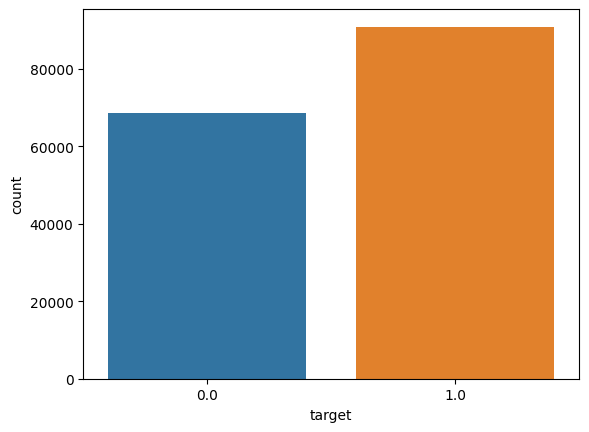

In [11]:
sns.countplot(x=y_train)

## HyperparameterSearch & Scoring


In [12]:
scoring = make_scorer(fbeta_score, beta=2)
# scoring = 'roc_auc'
cv = 5 #RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

## Model 3: XGBoost


In [13]:
xgboost_model = XGBClassifier(
    n_estimators=4000,
    learning_rate=0.01,  # Reduced learning rate
    max_depth=3,
    objective='binary:logistic',
    random_state=RSEED,
    scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
    gamma=0.1,  # Adjust gamma for regularization
    reg_lambda=1,  # Adjust reg_lambda for L2 regularization
    reg_alpha=0,  # Adjust reg_alpha for L1 regularization
)

In [14]:
pipe_boost = Pipeline([
    ('preprocessor', preprocessor),
    ('bo', xgboost_model)])

In [ ]:
# # don't forget to add the name of the model from the pipelin in front of each hyperparameter!
# param_st = {'st__dt__max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
#     'st__dt__max_leaf_nodes': [None] + list(np.arange(10, 51).astype(int)),
#     'st__dt__min_samples_split': [2, 5, 10],
#     'st__dt__max_depth': [None] + list(np.arange(3, 21).astype(int)),
#     'st__knn__n_neighbors' : np.arange(2,50), #this actually defines the model you use
#     'st__knn__weights' : ['uniform', 'distance'],
#     'st__knn__p' : [1, 2, 3],
#     'st__knn__algorithm': ['ball_tree', 'kd_tree', 'brute'],
#     'st__class__penalty':('l1','l2'),
#     'st__class__alpha': [0.001, 0.01, 0.1, 1, 10],
#     'st__class__learning_rate': ['optimal', 'constant', 'invscaling'],
#     'st__class__loss': ['log_loss', 'hinge', 'huber'],
#     'st__class__max_iter' : [1000, 500],
#     'st__class__eta0': [0.001, 0.01]
#     }

# randomsearch_st = RandomizedSearchCV(pipe_st, param_distributions=param_st, cv=cv, scoring=scoring, n_iter=10,
#                            verbose=5, n_jobs=-1) #evt. add error_score='raise'

In [15]:
# randomsearch_st.fit(X_train, y_train)
pipe_boost.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['consommation_sum',
                                                   'months_number'])])),
                ('bo',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_catego...
                               feature_types=None, gamma=0.1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=4000, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [ ]:
# Show best parameters
# print('Best score:\n{:.2f}'.format(randomsearch_st.best_score_))
# print("Best parameters:\n{}".format(randomsearch_st.best_params_))

In [ ]:
# Save best model (including fitted preprocessing steps) as best_model_st
# best_model_st = randomsearch_st.best_estimator_
# best_model_st

In [19]:
# best_model_st.score(X_test, y_test)

In [16]:
test_predictions_1 = pipe_boost.predict(X_test)
test_probs_1 = pipe_boost.predict_proba(X_test)[:, 1]


In [17]:
print(f'Test ROC AUC Score: {roc_auc_score(y_test, test_probs_1)}')
print(confusion_matrix(y_test, test_predictions_1))
print(classification_report(y_test, test_predictions_1))

Test ROC AUC Score: 0.6214563651435677
[[16254 15714]
 [  662  1229]]
              precision    recall  f1-score   support

         0.0       0.96      0.51      0.67     31968
         1.0       0.07      0.65      0.13      1891

    accuracy                           0.52     33859
   macro avg       0.52      0.58      0.40     33859
weighted avg       0.91      0.52      0.64     33859



In [18]:
# Make predictions for X_train
train_probs_2 = pipe_boost.predict_proba(X_train)[:, 1]
train_predictions_2 = pipe_boost.predict(X_train)

In [19]:
# Results X_train prediction:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs_2)}')
print(confusion_matrix(y_train, train_predictions_2))
print(classification_report(y_train, train_predictions_2))

Train ROC AUC Score: 0.792183904741125
[[39849 28681]
 [14215 76630]]
              precision    recall  f1-score   support

         0.0       0.74      0.58      0.65     68530
         1.0       0.73      0.84      0.78     90845

    accuracy                           0.73    159375
   macro avg       0.73      0.71      0.72    159375
weighted avg       0.73      0.73      0.72    159375

